# Covertype - Deep-Learning Classification

Data source: https://archive.ics.uci.edu/dataset/31/covertype

## Loading libraries, modules and data

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix



sns.set_theme()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [88]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 1660 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5



In [89]:
data = pd.read_csv('cover_data.csv')

In [90]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2                    581012 non-null 

In [91]:
data.head()

Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0       2596      51      3                               258   
1       2590      56      2                               212   
2       2804     139      9                               268   
3       2785     155     18                               242   
4       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            221             232            148   
1            220             235            151   
2            234             238            135   
3            238             238            122   
4            220             234            150   

   Horizontal_Distance_To_Fire_Points  ...  Soil_Type32  Soil_Type33  \
0                                6279  ...            0            0   
1                                6225  ...            0            0   
2                                6121  ...            0            0   
3                                6211  ...            0            0   
4                                6172  ...            0            0   

   Soil_Type34  Soil_Type35  Soil_Type36  Soil_Type37  Soil_Type38  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type39  Soil_Type40  class  
0            0            0      5  
1            0            0      5  
2            0            0      2  
3            0            0      2  
4            0            0      5  

[5 rows x 55 columns]

## EDA

**Classes belong to:**

 - Spruce/Fir
 - Lodgepole Pine
 - Ponderosa Pine
 - Cottonwood/Willow
 - Aspen
 - Douglas-fir
 - Krummholz

 Colums corresponding to Soil Type and Wilderness Area have already been one-hot encoded.

In [92]:
data.iloc[:,0:10] = data.iloc[:,0:10].astype('float')

In [93]:
features = data.iloc[:,0:-1]
labels = data.iloc[:,-1]

In [94]:
features.head()

Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0     2596.0    51.0    3.0                             258.0   
1     2590.0    56.0    2.0                             212.0   
2     2804.0   139.0    9.0                             268.0   
3     2785.0   155.0   18.0                             242.0   
4     2595.0    45.0    2.0                             153.0   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                             0.0                            510.0   
1                            -6.0                            390.0   
2                            65.0                           3180.0   
3                           118.0                           3090.0   
4                            -1.0                            391.0   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0          221.0           232.0          148.0   
1          220.0           235.0          151.0   
2          234.0           238.0          135.0   
3          238.0           238.0          122.0   
4          220.0           234.0          150.0   

   Horizontal_Distance_To_Fire_Points  ...  Soil_Type31  Soil_Type32  \
0                              6279.0  ...            0            0   
1                              6225.0  ...            0            0   
2                              6121.0  ...            0            0   
3                              6211.0  ...            0            0   
4                              6172.0  ...            0            0   

   Soil_Type33  Soil_Type34  Soil_Type35  Soil_Type36  Soil_Type37  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type38  Soil_Type39  Soil_Type40  
0            0            0            0  
1            0            0            0  
2            0            0            0  
3            0            0            0  
4            0            0            0  

[5 rows x 54 columns]

In [95]:
labels.unique()

array([5, 2, 1, 7, 3, 6, 4], dtype=int64)

In [96]:
labels = labels.apply(lambda x: x-1)

In [97]:
classes = list(labels.unique())
classes_dict = {'Spruce - Fir':0,'Lodgepole Pine':1, 'Ponderosa Pine':2, 'Cottonwood - Willow':3, 'Aspen':4, 'Douglas-fir':5, 'Krummholz':6}
inv_classes_dict = { val : key for key,val in classes_dict.items()}

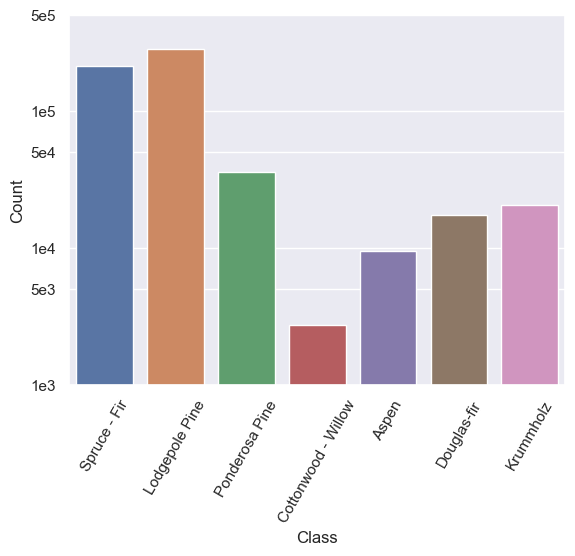

In [98]:
from collections import Counter
counts_dict = {val: dict(Counter(labels))[key] for key, val in inv_classes_dict.items()}
counts_df = pd.DataFrame(counts_dict.items(), columns=['Class','Count'])
fig = plt.figure()
ax = sns.barplot(data=counts_df,x='Class',y='Count')
ax.set_yscale('log')
ticks = [1000,5000,10000,50000,100000,500000]
ticks_labels = ['1e3','5e3','1e4','5e4','1e5','5e5']
ax.set_yticks(ticks)
ax.set_yticklabels(ticks_labels)
ax.set_xticklabels(rotation=60,labels=counts_df['Class'])
plt.show()

We can observe in the barplot above that the different classes to be predicted in this dataset are highly imbalanced. Different classes experience count differences spanning two orders of magnitude. To address this we opt to split the data twice, once for validation and once for testing, using a stratified strategy. 

c:\Users\jscru\.conda\envs\DS_python\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 640x480 with 0 Axes>

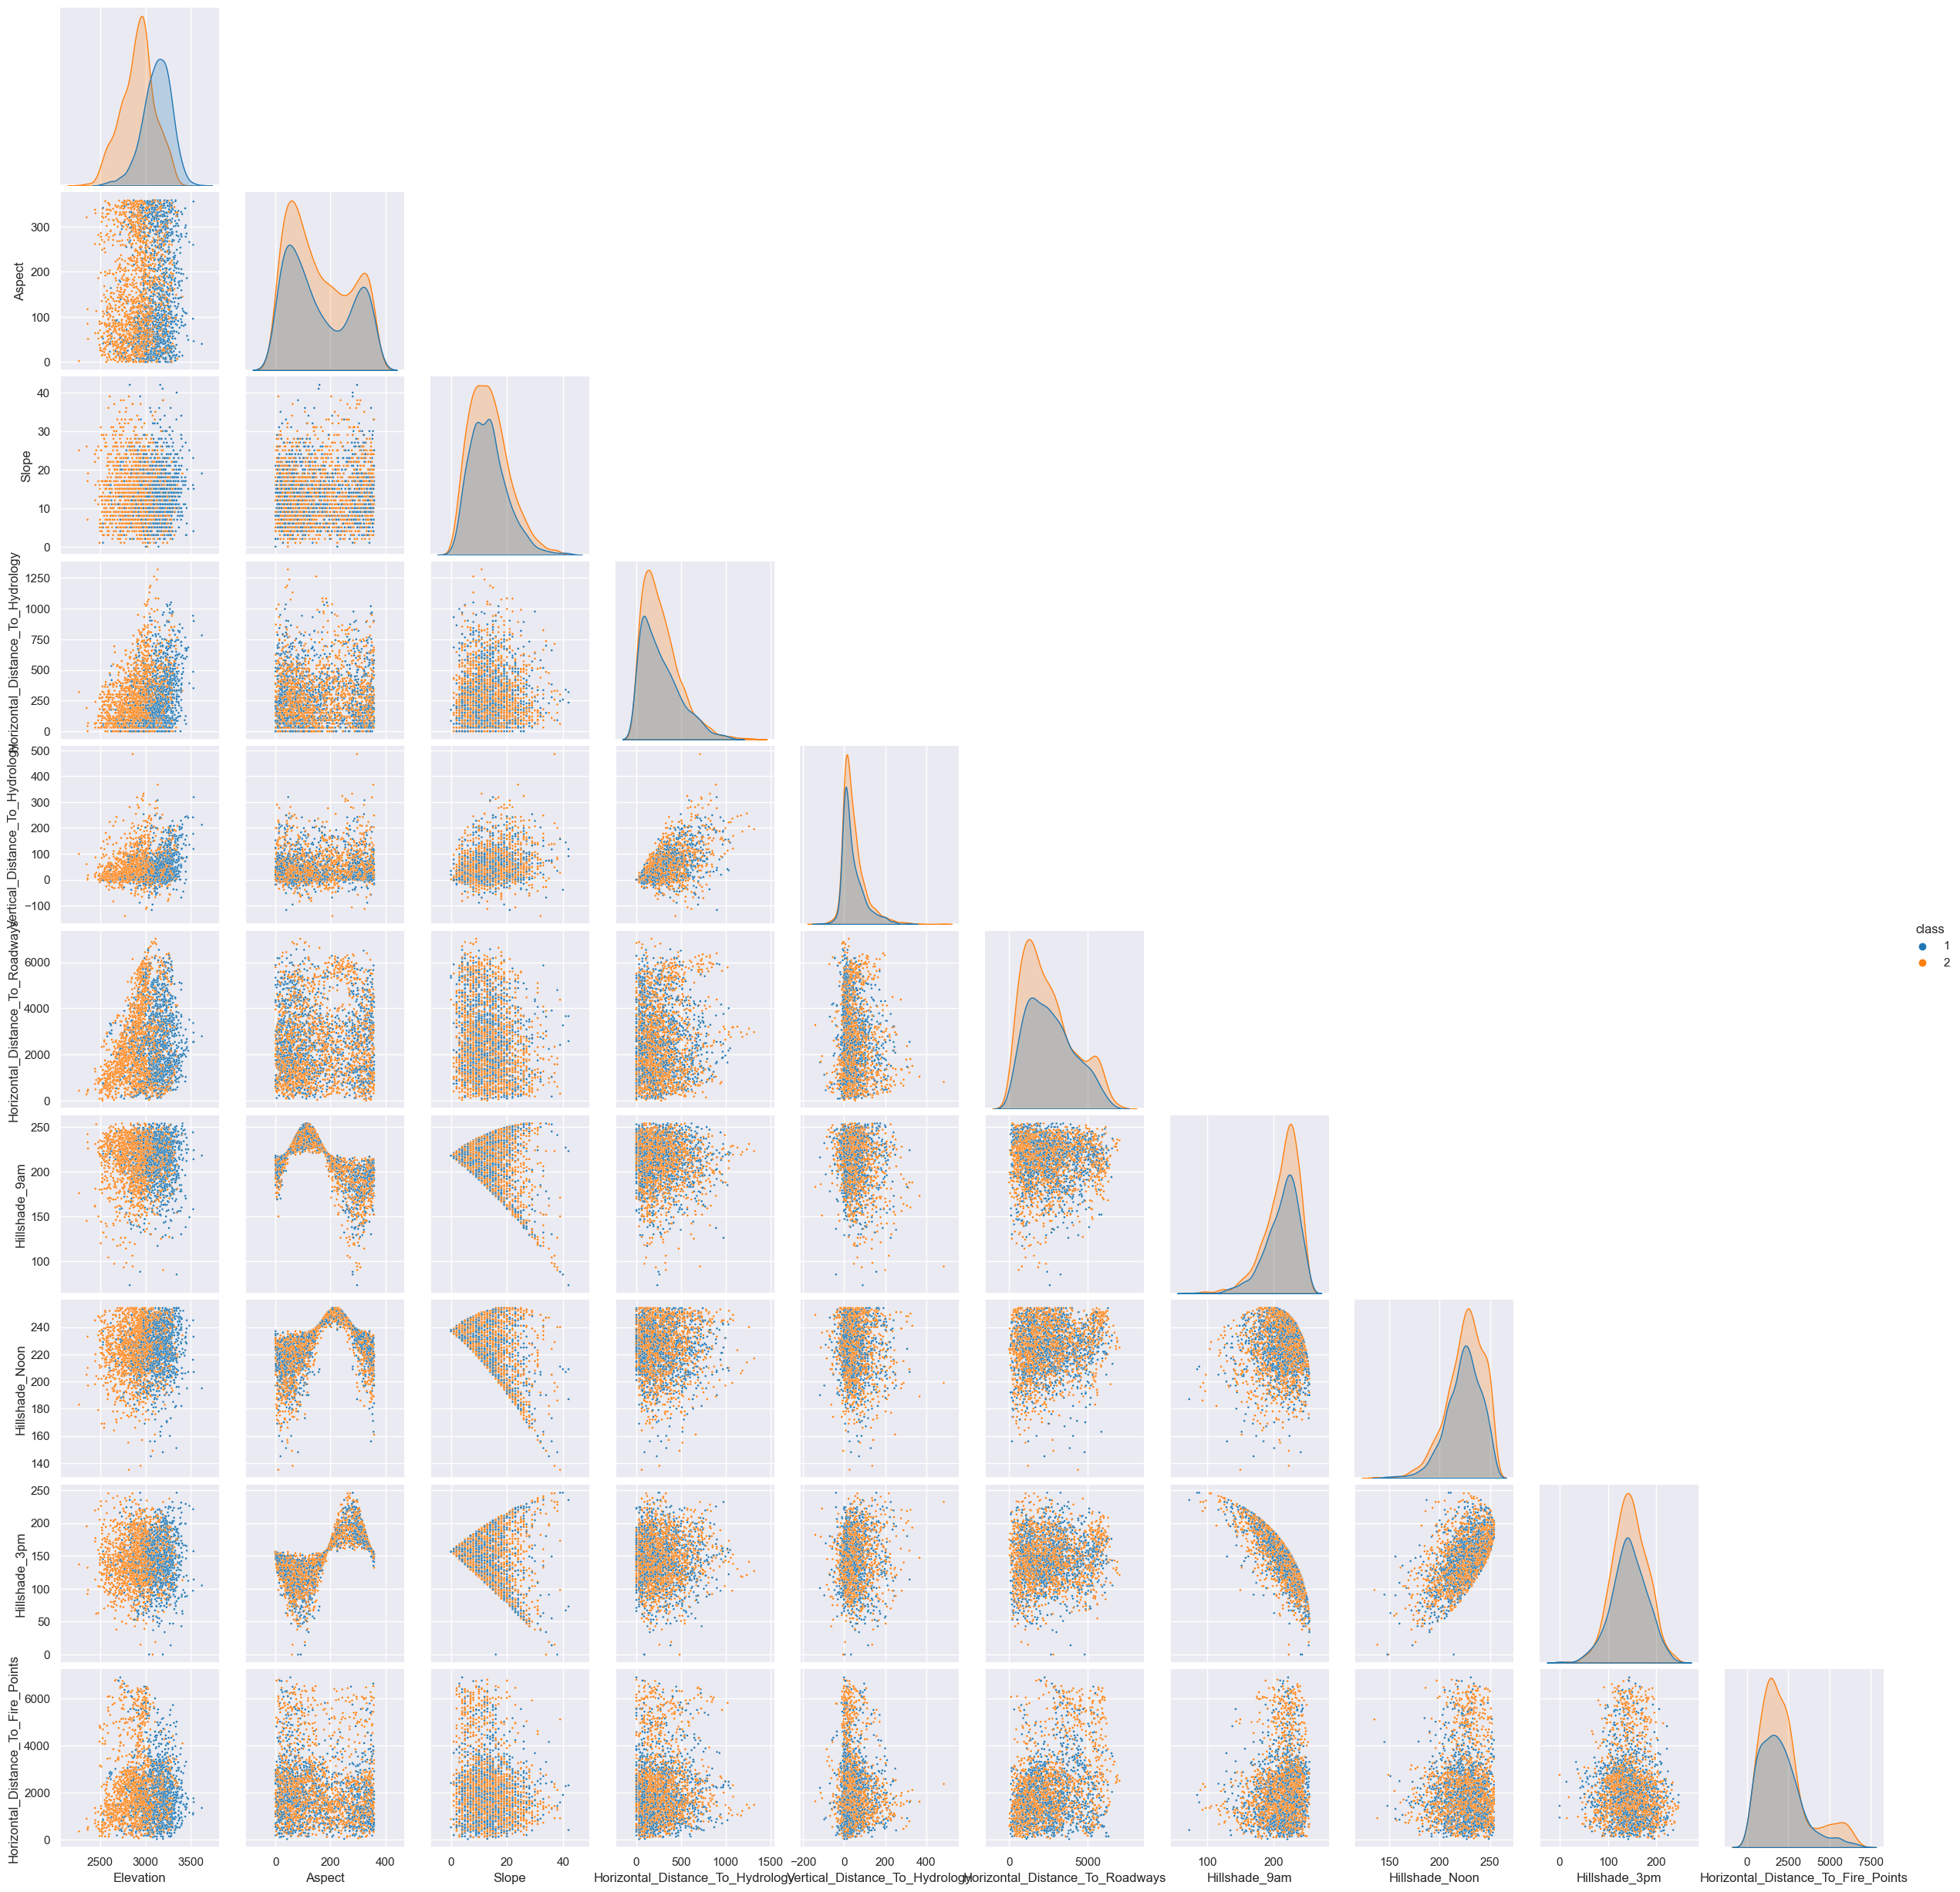

In [99]:
select_types = [classes_dict['Spruce - Fir']+1,classes_dict['Lodgepole Pine']+1]
data_reduced = data[data['class'].isin(select_types)].sample(n=3000)
data_reduced_f = data_reduced.iloc[:,0:10]
data_reduced_f['class'] = data_reduced.iloc[:,-1]
plt.figure()
plt.tight_layout()
my_palette = sns.color_palette('tab10')[0:len(select_types)]
sns.pairplot(data=data_reduced_f, hue='class', corner=True,palette=my_palette,plot_kws={'s':4})
plt.show()

The first two and most abundant classes show a high degeneracy regarding continuous features. Only the feature of `elevation` seems to be able to separate the two populations to a given extent.

[3, 4, 5, 6, 7]


c:\Users\jscru\.conda\envs\DS_python\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 640x480 with 0 Axes>

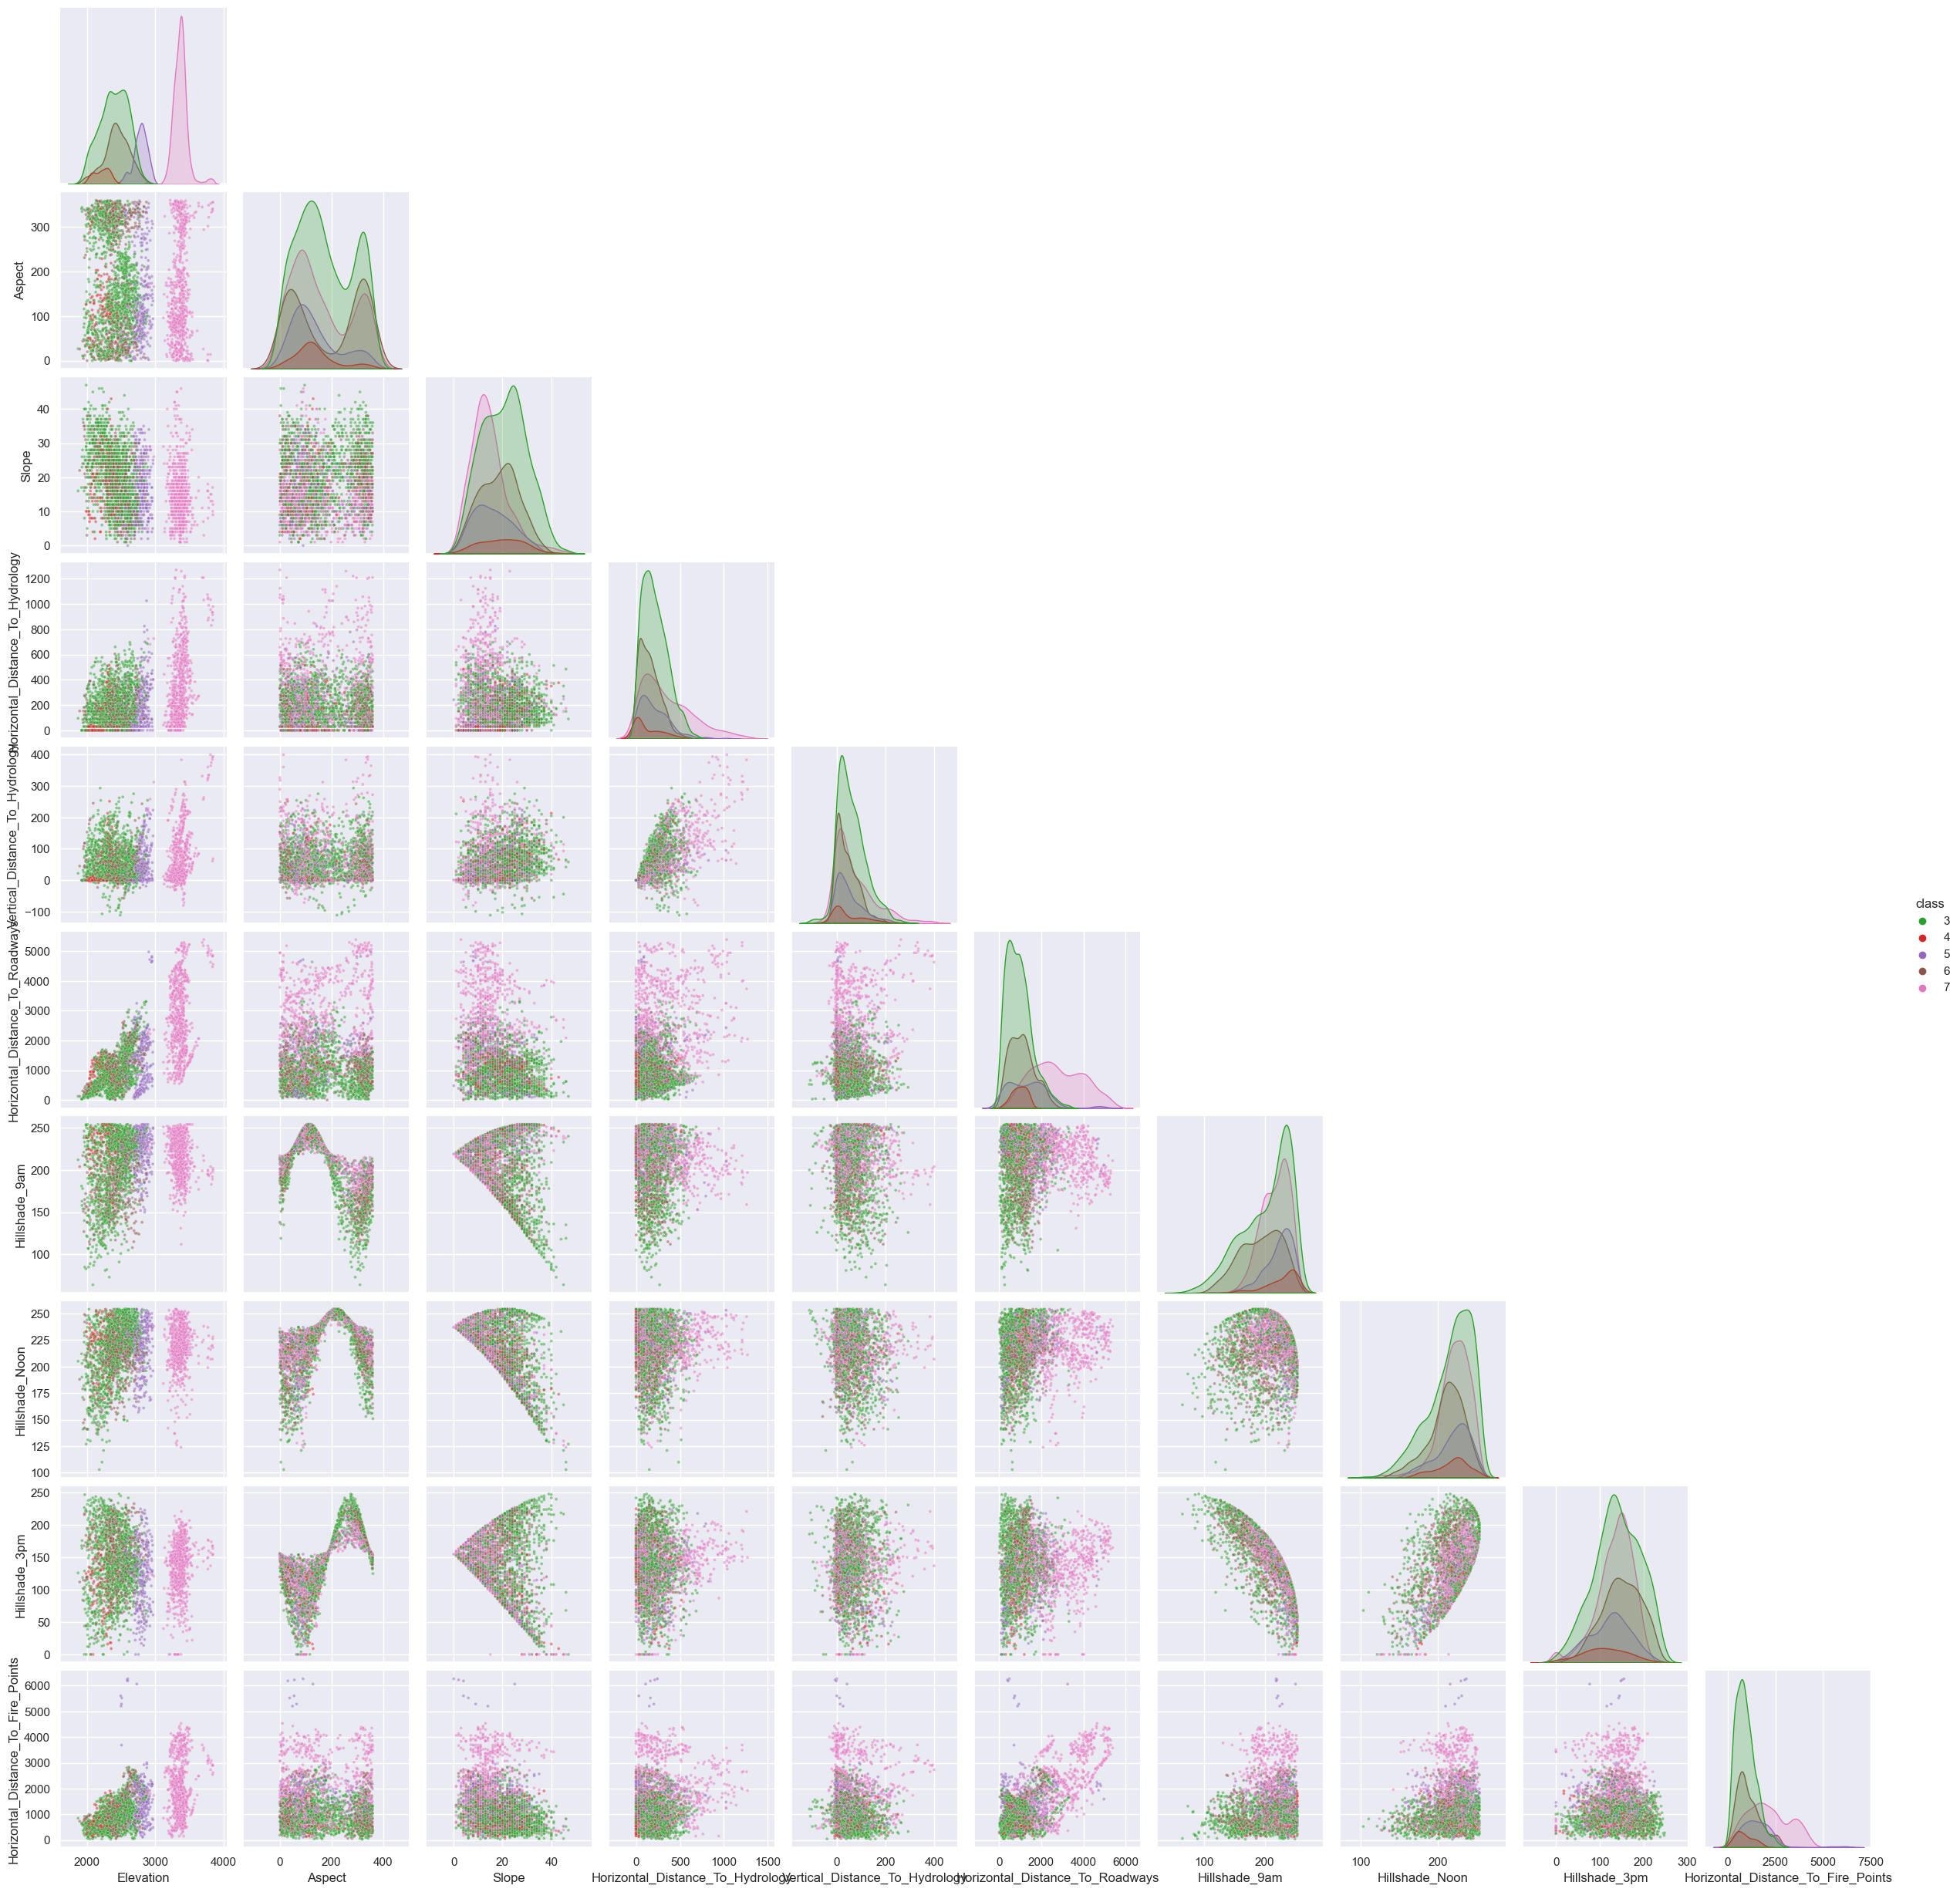

In [100]:
select_types = [classes_dict['Ponderosa Pine']+1,
                classes_dict['Cottonwood - Willow']+1, 
                classes_dict['Aspen']+1, 
                classes_dict['Douglas-fir']+1,
                classes_dict['Krummholz']+1
                ]
print(select_types)
data_reduced = data[data['class'].isin(select_types)].sample(n=3000)
data_reduced_f = data_reduced.iloc[:,0:10]
data_reduced_f['class'] = data_reduced.iloc[:,-1]
plt.figure()
plt.tight_layout()
my_palette = sns.color_palette('tab10')[2:len(select_types)+2]
sns.pairplot(data=data_reduced_f, hue='class', corner=True,palette=my_palette,plot_kws={'s':8, 'alpha':0.5})
plt.show()

Similar correlations can be observed in the remaining classes, where the feature `elevation` seems to be the most discerning one. The binary features `Soil_Type`s and `Wilderness_Area`s will play an important role in the classification.

495141


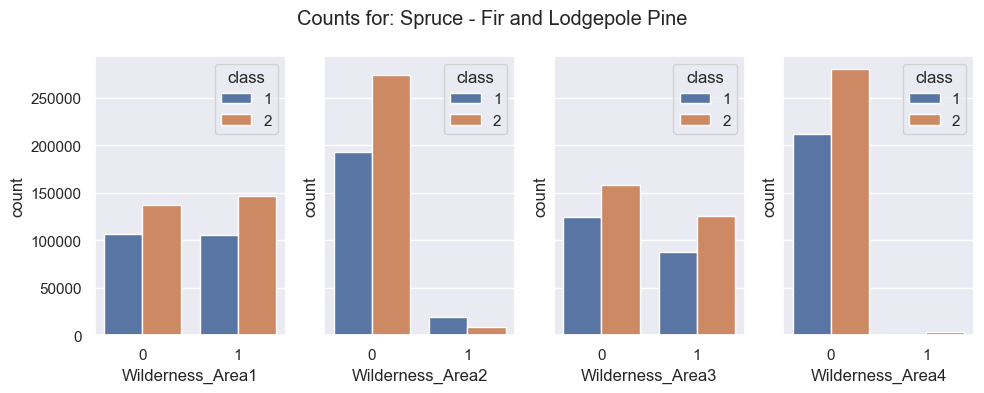

In [101]:
select = data[data['class'].isin([1,2])]
print(len(select))
fig = plt.figure(figsize=(10,4))
axs = fig.subplots(1,4,sharey=True)
plt.subplot(1,4,1)
sns.countplot(data=select,x='Wilderness_Area1', hue='class')
plt.subplot(1,4,2)
sns.countplot(data=select,x='Wilderness_Area2', hue='class')
plt.subplot(1,4,3)
sns.countplot(data=select,x='Wilderness_Area3', hue='class')
plt.subplot(1,4,4)
sns.countplot(data=select,x='Wilderness_Area4', hue='class')
plt.suptitle('Counts for: '+ inv_classes_dict[0] + ' and ' + inv_classes_dict[1])
plt.tight_layout()
plt.show()

The two most common cover types are found in very similar proportions in the four areas considered, making it hard to separate the two classes via these features.

9493


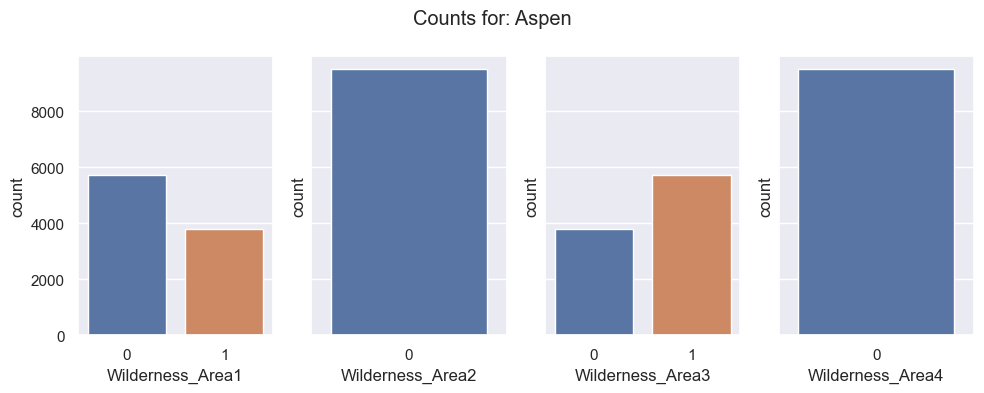

In [102]:
minority = data[data['class']==5]
print(len(minority))
fig = plt.figure(figsize=(10,4))
axs = fig.subplots(1,4,sharey=True)
plt.subplot(1,4,1)
ax = sns.countplot(data=minority,x='Wilderness_Area1')
plt.subplot(1,4,2)
sns.countplot(data=minority,x='Wilderness_Area2')
plt.subplot(1,4,3)
sns.countplot(data=minority,x='Wilderness_Area3')
plt.subplot(1,4,4)
sns.countplot(data=minority,x='Wilderness_Area4')
plt.suptitle('Counts for: '+ inv_classes_dict[4])
plt.tight_layout()
plt.show()

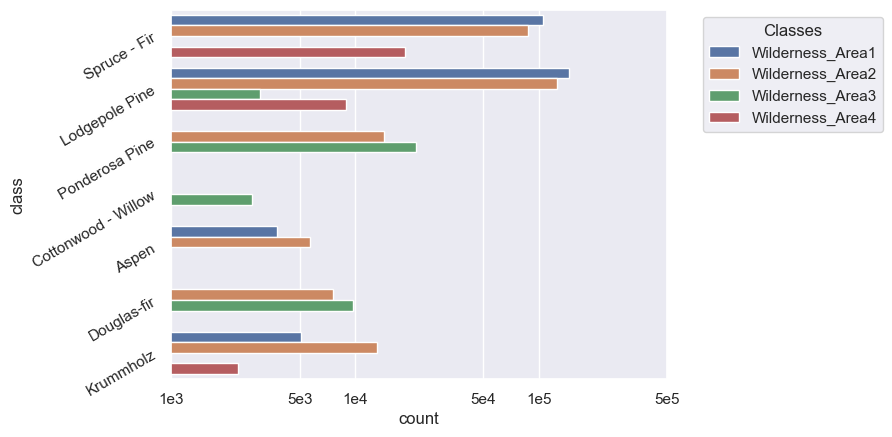

In [103]:
fig = plt.figure()
data_melt_loc = data.iloc[:,10:14]
loc_cols = data_melt_loc.columns
data_melt_loc['location'] = ''
data_melt_loc['class'] = data.iloc[:,-1]
for col in loc_cols:
    data_melt_loc.loc[data_melt_loc[col]==1, 'location'] = col
# print(data_melt_loc.head())
ax = sns.countplot(data=data_melt_loc,y='class',hue='location',orient='h')
plt.legend(title='Classes', labels=loc_cols, bbox_to_anchor=(1.45,1.0))
plt.xscale('log')
ticks = [1000,5000,10000,50000,100000,500000]
ticks_labels = ['1e3','5e3','1e4','5e4','1e5','5e5']
ax.set_xticks(ticks)
ax.set_xticklabels(ticks_labels)
ytick_labels = classes_dict.keys()
ax.set_yticklabels(ytick_labels, rotation=30)
plt.show()

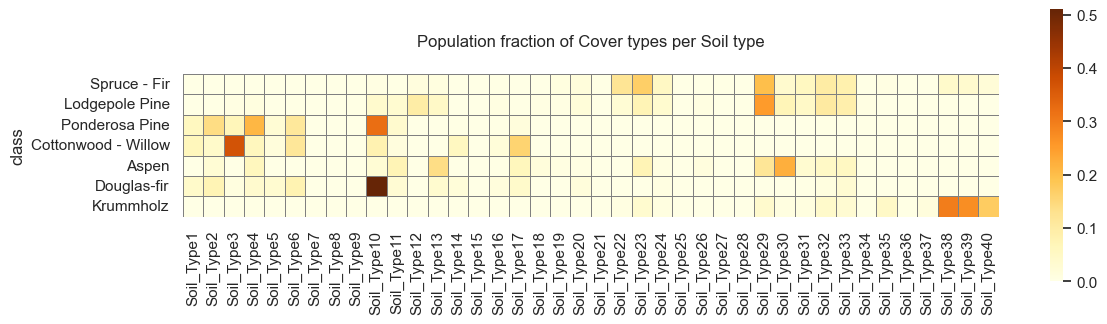

In [104]:
data_soil = data.iloc[:,14::].groupby(['class']).sum()
soil_types = list(data_soil.columns)
data_soil = data_soil.apply(lambda row: row/row.sum(), axis=1)
fig = plt.figure(figsize=(6,8))
ax = fig.add_axes([1,1,1.7,1.7])
ax = sns.heatmap(data=data_soil, cmap='YlOrBr', square=True, cbar=True, cbar_kws={'shrink':0.2}, linewidths=.5, linecolor='grey', ax=ax)
ax.set_yticklabels(classes_dict, rotation=0)
plt.title('Population fraction of Cover types per Soil type', pad=20)
# plt.tight_layout()
plt.show()


## Splitting and Preprocessing

In [105]:
label_cats = to_categorical(labels,dtype='int')
features_train, features_test, labels_train_full, labels_test = train_test_split(features,label_cats,test_size=.2,stratify=labels)

In [106]:
numerical_features = features.select_dtypes(include=['float64'])
numerical_columns = numerical_features.columns

ct = ColumnTransformer([('only numeric',StandardScaler(),numerical_columns)], remainder='passthrough')
features_train_scaled = ct.fit_transform(features_train)
features_test_scaled = ct.transform(features_test)

features_train_scaled = normalize(features_train_scaled)
features_test_scaled = normalize(features_test_scaled)

In [107]:
features_train, features_val, labels_train, labels_val = train_test_split(features_train_scaled,labels_train_full,test_size=.2,stratify=labels_train_full)

## Building and fitting the model

In [108]:
def categorical_to_int(data):
    return np.argmax(data,axis=1)

In [109]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=37,criterion='gini',class_weight='balanced')
tree.fit(features_train,categorical_to_int(labels_train))
print(tree.score(features_train,categorical_to_int(labels_train)))
print(tree.score(features_val,categorical_to_int(labels_val)))
print(tree.score(features_test,categorical_to_int(labels_test)))

0.9907246797742082
0.896549127600525
0.36054146622720584


c:\Users\jscru\.conda\envs\DS_python\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [110]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=150,
                max_depth=40, 
                n_jobs=-1,
                # min_samples_leaf=0.000001, 
                criterion='entropy',
                class_weight='balanced_subsample',
                verbose=1
                )
rf.fit(features_train,categorical_to_int(labels_train))
print(rf.score(features_test,categorical_to_int(labels_test)))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
c:\Users\jscru\.conda\envs\DS_python\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


0.37012813782776693


[Parallel(n_jobs=12)]: Done 150 out of 150 | elapsed:    0.4s finished


In [111]:
model_histories = []

We first train a simple model with only one hidden layer and relu activation functionn.

In [112]:
def model_simple(hidden_layer_size, opt, learning_rate):
    my_model = Sequential(name='Forest_simple')
    input = InputLayer(input_shape = (features.shape[1], ))
    my_model.add(input)
    my_model.add(Dense(hidden_layer_size,activation='relu'))
    my_model.add(Dense(len(classes),activation='softmax'))
    opt.learning_rate.assign(learning_rate)
    my_model.compile(loss =tf.keras.losses.CategoricalCrossentropy(), metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC(name='auc')], optimizer = opt)
    print(my_model.summary())
    return my_model


In [113]:
model_0 = model_simple(48,SGD(),0.7)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 20)
history_simple = model_0.fit(features_train,labels_train,epochs=100, batch_size=3000,verbose=1,validation_data=(features_val,labels_val), callbacks=[es])
model_histories.append(history_simple)

Model: "Forest_simple"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 48)                2640      
                                                                 
 dense_1 (Dense)             (None, 7)                 343       
                                                                 
Total params: 2,983
Trainable params: 2,983
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
124/124 [==============================] - 3s 9ms/step - loss: 0.9273 - categorical_accuracy: 0.6445 - auc: 0.9278 - val_loss: 0.7872 - val_categorical_accuracy: 0.6832 - val_auc: 0.9457
Epoch 2/100
124/124 [==============================] - 1s 7ms/step - loss: 0.7456 - categorical_accuracy: 0.6882 - auc: 0.9504 - val_loss: 0.7539 - val_categorical_accuracy: 0.6686 - val_auc: 0.9486
Epoch 3/100
124/124 [=======================

In [114]:
model_1 = model_simple(48,Adam(),0.1)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 20)
history_simple_1 = model_1.fit(features_train,labels_train,epochs=100, batch_size=3000,verbose=1,validation_data=(features_val,labels_val), callbacks=[es])
model_histories.append(history_simple_1)

Model: "Forest_simple"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 48)                2640      
                                                                 
 dense_3 (Dense)             (None, 7)                 343       
                                                                 
Total params: 2,983
Trainable params: 2,983
Non-trainable params: 0
_________________________________________________________________


None
Epoch 1/100
124/124 [==============================] - 1s 8ms/step - loss: 0.6383 - categorical_accuracy: 0.7285 - auc: 0.9623 - val_loss: 0.5401 - val_categorical_accuracy: 0.7679 - val_auc: 0.9724
Epoch 2/100
124/124 [==============================] - 1s 6ms/step - loss: 0.5198 - categorical_accuracy: 0.7745 - auc: 0.9739 - val_loss: 0.5084 - val_categorical_accuracy: 0.7800 - val_auc: 0.9751
Epoch 3/100
124/124 [==============================] - 1s 6ms/step - loss: 0.4927 - categorical_accuracy: 0.7873 - auc: 0.9765 - val_loss: 0.4821 - val_categorical_accuracy: 0.7926 - val_auc: 0.9775
Epoch 4/100
124/124 [==============================] - 1s 6ms/step - loss: 0.4762 - categorical_accuracy: 0.7958 - auc: 0.9779 - val_loss: 0.4719 - val_categorical_accuracy: 0.8013 - val_auc: 0.9784
Epoch 5/100
124/124 [==============================] - 1s 6ms/step - loss: 0.4717 - categorical_accuracy: 0.7981 - auc: 0.9783 - val_loss: 0.4711 - val_categorical_accuracy: 0.7990 - val_auc: 0.9783


The models with one hidden layer do not surpass .83 accuracy on the training set, let us see if increasing the complexity of the model results in higher accuracy.

In [115]:
def model_2hidd(hidden_layer_size,n_hidden_layers, opt, learning_rate):
    my_model = Sequential(name='Forest_2hidden')
    input = InputLayer(input_shape = (features.shape[1], ))
    my_model.add(input)
    # for i in range(n_hidden_layers):
    my_model.add(Dense(hidden_layer_size,activation='relu'))
    # my_model.add(Dense(hidden_layer_size,activation='tanh'))
    # my_model.add(Dense(hidden_layer_size,activation='sigmoid'))
    my_model.add(Dense(hidden_layer_size/2,activation='tanh'))
    # my_model.add(Dense(hidden_layer_size/3,activation='relu'))
        
    my_model.add(Dense(len(classes),activation='softmax'))
    opt.learning_rate.assign(learning_rate)
    my_model.compile(loss =tf.keras.losses.CategoricalCrossentropy(), metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC(name='auc')], optimizer = opt)
    print(my_model.summary())
    return my_model

In [116]:
model_2 = model_2hidd(48,1,Adam(),0.1)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 20)
history_model_2 = model_2.fit(features_train,labels_train,epochs=100, batch_size=3000,verbose=1,validation_data=(features_val,labels_val), callbacks=[es])
model_histories.append(history_model_2)

Model: "Forest_2hidden"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 48)                2640      
                                                                 
 dense_5 (Dense)             (None, 24)                1176      
                                                                 
 dense_6 (Dense)             (None, 7)                 175       
                                                                 
Total params: 3,991
Trainable params: 3,991
Non-trainable params: 0
_________________________________________________________________


None
Epoch 1/100
124/124 [==============================] - 1s 8ms/step - loss: 0.6709 - categorical_accuracy: 0.7154 - auc: 0.9588 - val_loss: 0.5357 - val_categorical_accuracy: 0.7730 - val_auc: 0.9728
Epoch 2/100
124/124 [==============================] - 1s 7ms/step - loss: 0.5069 - categorical_accuracy: 0.7857 - auc: 0.9755 - val_loss: 0.4788 - val_categorical_accuracy: 0.7998 - val_auc: 0.9781
Epoch 3/100
124/124 [==============================] - 1s 6ms/step - loss: 0.4640 - categorical_accuracy: 0.8042 - auc: 0.9794 - val_loss: 0.4494 - val_categorical_accuracy: 0.8105 - val_auc: 0.9807
Epoch 4/100
124/124 [==============================] - 1s 6ms/step - loss: 0.4406 - categorical_accuracy: 0.8139 - auc: 0.9813 - val_loss: 0.4407 - val_categorical_accuracy: 0.8146 - val_auc: 0.9813
Epoch 5/100
124/124 [==============================] - 1s 6ms/step - loss: 0.4255 - categorical_accuracy: 0.8210 - auc: 0.9825 - val_loss: 0.4293 - val_categorical_accuracy: 0.8208 - val_auc: 0.9821


The model still does not surpass .83 percent so we increase the depth 

In [117]:
def model_3hidd(hidden_layer_size,n_hidden_layers, opt, learning_rate):
    my_model = Sequential(name='Forest_3hidd')
    input = InputLayer(input_shape = (features.shape[1], ))
    my_model.add(input)
    for i in range(n_hidden_layers):
        my_model.add(Dense(hidden_layer_size,activation='relu'))
        my_model.add(Dense(hidden_layer_size,activation='tanh'))
        # my_model.add(Dense(hidden_layer_size,activation='sigmoid'))
        my_model.add(Dense(hidden_layer_size/2,activation='tanh'))
        # my_model.add(Dense(hidden_layer_size/3,activation='relu'))
        
    my_model.add(Dense(len(classes),activation='softmax'))
    opt.learning_rate.assign(learning_rate)
    my_model.compile(loss =tf.keras.losses.CategoricalCrossentropy(), metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC(name='auc')], optimizer = opt)
    print(my_model.summary())
    return my_model

In [118]:
model_3 = model_3hidd(48,1,Adam(),0.05)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 20)
history_model_3 = model_3.fit(features_train,labels_train,epochs=100, batch_size=3000,verbose=1,validation_data=(features_val,labels_val), callbacks=[es])
model_histories.append(history_model_3)

Model: "Forest_3hidd"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 48)                2640      
                                                                 
 dense_8 (Dense)             (None, 48)                2352      
                                                                 
 dense_9 (Dense)             (None, 24)                1176      
                                                                 
 dense_10 (Dense)            (None, 7)                 175       
                                                                 
Total params: 6,343
Trainable params: 6,343
Non-trainable params: 0
_________________________________________________________________


None
Epoch 1/100
124/124 [==============================] - 2s 9ms/step - loss: 0.6754 - categorical_accuracy: 0.7125 - auc: 0.9583 - val_loss: 0.5503 - val_categorical_accuracy: 0.7647 - val_auc: 0.9712
Epoch 2/100
124/124 [==============================] - 1s 7ms/step - loss: 0.5152 - categorical_accuracy: 0.7808 - auc: 0.9747 - val_loss: 0.4837 - val_categorical_accuracy: 0.7961 - val_auc: 0.9777
Epoch 3/100
124/124 [==============================] - 1s 7ms/step - loss: 0.4665 - categorical_accuracy: 0.8040 - auc: 0.9792 - val_loss: 0.4477 - val_categorical_accuracy: 0.8125 - val_auc: 0.9809
Epoch 4/100
124/124 [==============================] - 1s 7ms/step - loss: 0.4348 - categorical_accuracy: 0.8179 - auc: 0.9818 - val_loss: 0.4218 - val_categorical_accuracy: 0.8232 - val_auc: 0.9828
Epoch 5/100
124/124 [==============================] - 1s 7ms/step - loss: 0.4102 - categorical_accuracy: 0.8293 - auc: 0.9837 - val_loss: 0.4028 - val_categorical_accuracy: 0.8335 - val_auc: 0.9842


The model now reaches almost .87 accuracy on training data, meaning we can push it further by still adding complexity.

In [119]:
def model_hidds(hidden_layer_size,n_hidden_layers, opt, learning_rate):
    my_model = Sequential(name='Forest_hidds')
    input = InputLayer(input_shape = (features.shape[1], ))
    my_model.add(input)
    for i in range(n_hidden_layers):
        my_model.add(Dense(hidden_layer_size,activation='relu'))
        # my_model.add(Dense(hidden_layer_size,activation='tanh'))
        # my_model.add(Dense(hidden_layer_size,activation='sigmoid'))
    my_model.add(Dense(hidden_layer_size/2,activation='tanh'))
        # my_model.add(Dense(hidden_layer_size/3,activation='relu'))
        
    my_model.add(Dense(len(classes),activation='softmax'))
    opt.learning_rate.assign(learning_rate)
    my_model.compile(loss =tf.keras.losses.CategoricalCrossentropy(), metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC(name='auc')], optimizer = opt)
    print(my_model.summary())
    return my_model

In [120]:
model_4 = model_hidds(48,3,Adam(),0.02)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 20)
history_model_4 = model_4.fit(features_train,labels_train,epochs=100, batch_size=3000,verbose=1,validation_data=(features_val,labels_val), callbacks=[es])
model_histories.append(history_model_4)

Model: "Forest_hidds"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 48)                2640      
                                                                 
 dense_12 (Dense)            (None, 48)                2352      
                                                                 
 dense_13 (Dense)            (None, 48)                2352      
                                                                 
 dense_14 (Dense)            (None, 24)                1176      
                                                                 
 dense_15 (Dense)            (None, 7)                 175       
                                                                 
Total params: 8,695
Trainable params: 8,695
Non-trainable params: 0


_________________________________________________________________
None
Epoch 1/100
124/124 [==============================] - 2s 10ms/step - loss: 0.6958 - categorical_accuracy: 0.7111 - auc: 0.9569 - val_loss: 0.5683 - val_categorical_accuracy: 0.7563 - val_auc: 0.9699
Epoch 2/100
124/124 [==============================] - 1s 7ms/step - loss: 0.5219 - categorical_accuracy: 0.7776 - auc: 0.9741 - val_loss: 0.4970 - val_categorical_accuracy: 0.7884 - val_auc: 0.9764
Epoch 3/100
124/124 [==============================] - 1s 7ms/step - loss: 0.4732 - categorical_accuracy: 0.7988 - auc: 0.9785 - val_loss: 0.4535 - val_categorical_accuracy: 0.8070 - val_auc: 0.9803
Epoch 4/100
124/124 [==============================] - 1s 7ms/step - loss: 0.4401 - categorical_accuracy: 0.8149 - auc: 0.9813 - val_loss: 0.4310 - val_categorical_accuracy: 0.8182 - val_auc: 0.9821
Epoch 5/100
124/124 [==============================] - 1s 7ms/step - loss: 0.4216 - categorical_accuracy: 0.8238 - auc: 0.9828 - val

The model is now able to reach .88 percent but is still stopping early. Let us try changing the activation functions to introduce more non-linearities.

In [121]:
def model_hidds_act(hidden_layer_size,n_hidden_layers, opt, learning_rate):
    my_model = Sequential(name='Forest_hidds_act')
    input = InputLayer(input_shape = (features.shape[1], ))
    my_model.add(input)
    for i in range(n_hidden_layers):
        my_model.add(Dense(hidden_layer_size,activation='relu'))
        my_model.add(Dense(hidden_layer_size,activation='tanh'))
        my_model.add(Dense(hidden_layer_size,activation='sigmoid'))
    my_model.add(Dense(hidden_layer_size/2,activation='tanh'))
        # my_model.add(Dense(hidden_layer_size/3,activation='relu'))
        
    my_model.add(Dense(len(classes),activation='softmax'))
    opt.learning_rate.assign(learning_rate)
    my_model.compile(loss =tf.keras.losses.CategoricalCrossentropy(), metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC(name='auc')], optimizer = opt)
    print(my_model.summary())
    return my_model

In [122]:
model_5 = model_hidds_act(52,1,Adam(),0.02)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 20)
history_model_5 = model_5.fit(features_train,labels_train,epochs=100, batch_size=3000,verbose=1,validation_data=(features_val,labels_val), callbacks=[es])
model_histories.append(history_model_5)

Model: "Forest_hidds_act"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 52)                2860      
                                                                 
 dense_17 (Dense)            (None, 52)                2756      
                                                                 
 dense_18 (Dense)            (None, 52)                2756      
                                                                 


 dense_19 (Dense)            (None, 26)                1378      
                                                                 
 dense_20 (Dense)            (None, 7)                 189       
                                                                 
Total params: 9,939
Trainable params: 9,939
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
124/124 [==============================] - 2s 9ms/step - loss: 0.7606 - categorical_accuracy: 0.6920 - auc: 0.9495 - val_loss: 0.6076 - val_categorical_accuracy: 0.7516 - val_auc: 0.9659
Epoch 2/100
124/124 [==============================] - 1s 7ms/step - loss: 0.5551 - categorical_accuracy: 0.7695 - auc: 0.9711 - val_loss: 0.5292 - val_categorical_accuracy: 0.7757 - val_auc: 0.9735
Epoch 3/100
124/124 [==============================] - 1s 7ms/step - loss: 0.5047 - categorical_accuracy: 0.7887 - auc: 0.9756 - val_loss: 0.4784 - val_categorical_accuracy: 0.8019 - val_auc: 0.9781


We are reaching 91 percent but still stopping early.

In [123]:
def model_best(hidden_layer_size,n_hidden_layers, opt, learning_rate):
    my_model = Sequential(name='ForestNN')
    input = InputLayer(input_shape = (features.shape[1], ))
    my_model.add(input)
    for i in range(n_hidden_layers):
        my_model.add(Dense(hidden_layer_size,activation='relu'))
        my_model.add(Dense(hidden_layer_size,activation='tanh'))
        my_model.add(Dense(hidden_layer_size,activation='sigmoid'))
        my_model.add(Dense(hidden_layer_size/2,activation='tanh'))
        my_model.add(Dense(hidden_layer_size/3,activation='relu'))
        
    my_model.add(Dense(len(classes),activation='softmax'))
    opt.learning_rate.assign(learning_rate)
    my_model.compile(loss =tf.keras.losses.CategoricalCrossentropy(), metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC(name='auc')], optimizer = opt)
    print(my_model.summary())
    return my_model

In [124]:
# model = model_with(50, 1, Adam(), 0.011) # acc: 0.92
model = model_best(52, 1, Adam(), 0.012) 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 30)
history = model.fit(features_train,labels_train,epochs=200, batch_size=3000,verbose=1,validation_data=(features_val,labels_val), callbacks=[es])
model_histories.append(history)

Model: "ForestNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 52)                2860      
                                                                 
 dense_22 (Dense)            (None, 52)                2756      
                                                                 
 dense_23 (Dense)            (None, 52)                2756      
                                                                 
 dense_24 (Dense)            (None, 26)                1378      
                                                                 
 dense_25 (Dense)            (None, 17)                459       
                                                                 
 dense_26 (Dense)            (None, 7)                 126       
                                                                 
Total params: 10,335
Trainable params: 10,335
Non-trainabl

In [125]:
def model_last(hidden_layer_size,n_hidden_layers, opt, learning_rate):
    my_model = Sequential(name='ForestNN')
    input = InputLayer(input_shape = (features.shape[1], ))
    my_model.add(input)
    for i in range(n_hidden_layers):
        my_model.add(Dense(hidden_layer_size,activation='relu'))
        my_model.add(Dense(hidden_layer_size,activation='tanh'))
        my_model.add(Dense(hidden_layer_size,activation='sigmoid'))
        my_model.add(Dense(hidden_layer_size,activation='relu'))
    my_model.add(Dense(hidden_layer_size/2,activation='tanh'))
    my_model.add(Dense(hidden_layer_size/3,activation='relu'))
        
    my_model.add(Dense(len(classes),activation='softmax'))
    opt.learning_rate.assign(learning_rate)
    my_model.compile(loss =tf.keras.losses.CategoricalCrossentropy(), metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC(name='auc')], optimizer = opt)
    print(my_model.summary())
    return my_model

In [126]:
# model = model_with(50, 1, Adam(), 0.011) # acc: 0.92
model_7 = model_last(52, 1, Adam(), 0.011) 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 30)
history_model_7 = model_7.fit(features_train,labels_train,epochs=200, batch_size=3000,verbose=1,validation_data=(features_val,labels_val), callbacks=[es])
model_histories.append(history_model_7)

Model: "ForestNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 52)                2860      
                                                                 
 dense_28 (Dense)            (None, 52)                2756      
                                                                 
 dense_29 (Dense)            (None, 52)                2756      
                                                                 
 dense_30 (Dense)            (None, 52)                2756      
                                                                 
 dense_31 (Dense)            (None, 26)                1378      
                                                                 
 dense_32 (Dense)            (None, 17)                459       
                                                                 
 dense_33 (Dense)            (None, 7)                 126

None
Epoch 1/200
124/124 [==============================] - 2s 9ms/step - loss: 0.7751 - categorical_accuracy: 0.6875 - auc: 0.9475 - val_loss: 0.6162 - val_categorical_accuracy: 0.7521 - val_auc: 0.9646
Epoch 2/200
124/124 [==============================] - 1s 8ms/step - loss: 0.5905 - categorical_accuracy: 0.7601 - auc: 0.9673 - val_loss: 0.5525 - val_categorical_accuracy: 0.7731 - val_auc: 0.9712
Epoch 3/200
124/124 [==============================] - 1s 8ms/step - loss: 0.5354 - categorical_accuracy: 0.7781 - auc: 0.9729 - val_loss: 0.5197 - val_categorical_accuracy: 0.7849 - val_auc: 0.9743
Epoch 4/200
124/124 [==============================] - 1s 8ms/step - loss: 0.5065 - categorical_accuracy: 0.7874 - auc: 0.9755 - val_loss: 0.4986 - val_categorical_accuracy: 0.7899 - val_auc: 0.9762
Epoch 5/200
124/124 [==============================] - 1s 8ms/step - loss: 0.4832 - categorical_accuracy: 0.7973 - auc: 0.9776 - val_loss: 0.4713 - val_categorical_accuracy: 0.8029 - val_auc: 0.9787


We have reached a point where adding a new layer does not improve the accuracy of the model.

## Evaluating the models

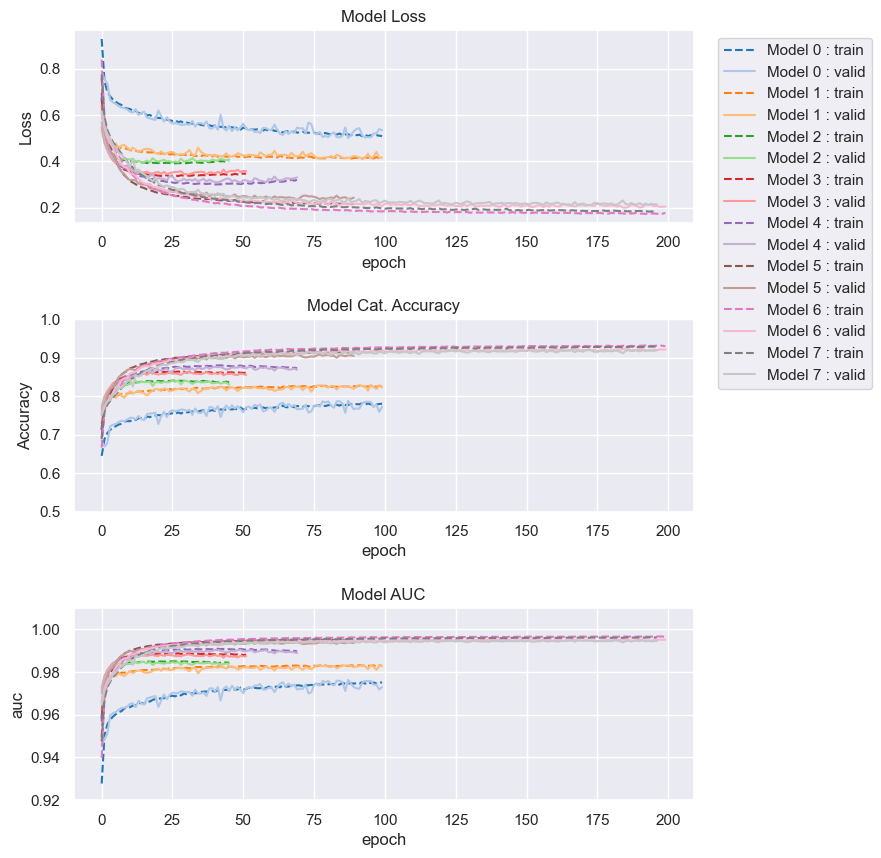

In [127]:
from matplotlib import colormaps

cmap = colormaps['tab20'].colors

fig = plt.figure(figsize=(8,10))
fig.subplots_adjust(hspace=0.5)
ax1 = fig.add_subplot(3, 1, 1)
for i in range(len(model_histories)):
    history = model_histories[i]
    plot_label_loss = 'Model ' + str(i) + ' : train'
    plot_label_loss_val = 'Model ' + str(i) + ' : valid'
    ax1.plot(history.history['loss'],color=cmap[2*i],linestyle='dashed',label=plot_label_loss)
    ax1.plot(history.history['val_loss'],color=cmap[2*i + 1 ],label=plot_label_loss_val)
ax1.set_title('Model Loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('Loss')
# ax1.set_ylim(0.0,1.0)
ax1.legend(loc='upper right', bbox_to_anchor=(1.3,1))

ax1 = fig.add_subplot(3, 1, 2)
for i in range(len(model_histories)):
    history = model_histories[i]
    ax1.plot(history.history['categorical_accuracy'],color=cmap[2*i],linestyle='dashed')
    ax1.plot(history.history['val_categorical_accuracy'],color=cmap[2*i + 1 ])
ax1.set_title('Model Cat. Accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0.5,1.0)
# ax1.legend(['train', 'validation'], loc='lower right')

# plotting auc and validation auc over epochs
ax2 = fig.add_subplot(3, 1, 3)
for i in range(len(model_histories)):
    history = model_histories[i]
    ax2.plot(history.history['auc'],color=cmap[2*i],linestyle='dashed')
    ax2.plot(history.history['val_auc'],color=cmap[2*i + 1 ])
ax2.set_title('Model AUC')
ax2.set_xlabel('epoch')
ax2.set_ylabel('auc')
ax2.set_ylim(0.92,1.01)
# ax2.legend(['train', 'validation'], loc='lower right')

# used to keep plots from overlapping
# fig.tight_layout()
plt.savefig('model_comp.pdf',bbox_inches='tight')
plt.show()

The plots above show the Loss function, Accuracy and AUC (Area under the curve) achieved after training different models with increasing complexity (Model 0 being the simplest). The best performing model is Model 6 which will be studied and still optimized further below. 

The best performing models found reach accuracy levels beyond 90% for the training and the validation dataset.

## Final training of the best model

In [128]:
def model_best(hidden_layer_size, opt, learning_rate):
    my_model = Sequential(name='CoverType_best')
    input = InputLayer(input_shape = (features.shape[1], ))
    my_model.add(input)
    my_model.add(Dense(hidden_layer_size,activation='relu'))
    my_model.add(Dense(hidden_layer_size+8,activation='tanh'))
    my_model.add(Dense(hidden_layer_size,activation='sigmoid'))
    my_model.add(Dense(hidden_layer_size/2,activation='tanh'))
    my_model.add(Dense(hidden_layer_size/3,activation='relu'))
    
    my_model.add(Dense(len(classes),activation='softmax'))
    opt.learning_rate.assign(learning_rate)
    my_model.compile(loss =tf.keras.losses.CategoricalCrossentropy(), metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC(name='auc')], optimizer = opt)
    print(my_model.summary())
    return my_model

Increasing the size of the layers now starts giving indications of overfitting.

In [129]:
model = model_best(52,Adam(),0.014)
history = model.fit(features_train_scaled,labels_train_full,epochs=200, batch_size=8192,verbose=1)

Model: "CoverType_best"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 52)                2860      
                                                                 
 dense_35 (Dense)            (None, 60)                3180      
                                                                 
 dense_36 (Dense)            (None, 52)                3172      
                                                                 
 dense_37 (Dense)            (None, 26)                1378      
                                                                 
 dense_38 (Dense)            (None, 17)                459       
                                                                 
 dense_39 (Dense)            (None, 7)                 126       
                                                                 
Total params: 11,175
Trainable params: 11,175
Non-tr

In [130]:
y_true = np.argmax(labels_test,axis=1)
y_true = [inv_classes_dict[est] for est in y_true]

In [131]:
y_estimate = model.predict(features_test_scaled)
y_estimate = np.argmax(y_estimate,axis=1)
y_estimate = [inv_classes_dict[est] for est in y_estimate]

print(classification_report(y_true, y_estimate))

3632/3632 [==============================] - 5s 1ms/step
                     precision    recall  f1-score   support

              Aspen       0.84      0.80      0.82      1899
Cottonwood - Willow       0.87      0.73      0.79       549
        Douglas-fir       0.84      0.87      0.85      3473
          Krummholz       0.93      0.94      0.94      4102
     Lodgepole Pine       0.95      0.93      0.94     56661
     Ponderosa Pine       0.91      0.93      0.92      7151
       Spruce - Fir       0.92      0.93      0.93     42368

           accuracy                           0.93    116203
          macro avg       0.89      0.88      0.89    116203
       weighted avg       0.93      0.93      0.93    116203



In [132]:
conf_mat = pd.DataFrame(confusion_matrix(y_true, y_estimate,labels=list(classes_dict.keys())),columns=list(classes_dict.keys()))
# print(conf_mat)
conf_mat.insert(0,'Class',classes_dict.keys())
# conf_mat = conf_mat.set_index('Class')

conf_mat.style.set_table_styles([{'selector':'th','props':[('text-align','center'),('font-size','8pt'),('font-weight','normal')]},{'selector':'td','props':[('text-align','center'),('font-size','9pt')]}]).hide()

## Conclusions and Remarks

#### Technical observations
- Generally increasing the number of hidden layers allows the Sequential model to classify the data with better accuracy up to a point. After having reached 3 Dense layers with a size almost equal to the number of features, improvement is negligible.
- Two dense layers with half and a third of the perceptrons of the initial three are seen to give good results.
- A pyramidal structure seems to be the better one for this case after, where each hidden layers consists of a fraction of the number of perceptrons of the previous layer.
- Increasing the batch_size improves classification for classes with low weights while learning rate can only be chosen as high as the stability of the optimizers permit.
- We have only manually explored the hyperparameters: `batch_size` and `learning_rate`, the model might enjoy slightly better performance if a more systematic search for hyperparameters is done.

#### Case study observations

- The dataset contains 7 different classes of cover types: 'Spruce - Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood - Willow', 'Aspen', 'Douglas-fir', 'Krummholz' of which the first two are way more abundant (by a factor of more than 10) than the other classes. 
- The 'Cottonwood - Willow' has a very small weight in the dataset with a support of only ~500 samples out of the close to 120,000.
- Analyzing the continuos parameters, many classes present very similar correlations making the classifying task quite hard. Specifically, 'Spruce - Fir' and 'Lodgepole Pine' are particularly difficult to differentiate with only continuous features. Even for the best classifier obtained above, they present the largest amount of erroneous predictions as seen in the confusion matrix. 
- The two categories with the lowest accuracy are however: 'Aspen' and 'Cottonwood - Willow' due to their low numbers.
- The classifier reaches an overall accuracy of 93%  
- To increase the accuracy further and break the degeneracy between 'Spruce - Fir' and 'Lodgepole Pine' it would be interesting to explore extending the available features, by collection of more data or feature engineering. 